In [5]:
#!pip install pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, substring, rand
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVCModel
import matplotlib.pyplot as plt
import os
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext


+----+-----+-----------+---------+----+-----+--------+-------------+-------+-----+
|time|month|temperature|feelslike|wind|cloud|pressure|      weather|predict|label|
+----+-----+-----------+---------+----+-----+--------+-------------+-------+-----+
|   1|    1|       24.0|     26.0| 8.0|  4.0|  1012.0|        Clear| norain|    0|
|   1|    1|       24.0|     27.0| 8.0|  4.0|  1011.0|        Clear| norain|    0|
|   1|    1|       24.0|     26.0| 8.0|  7.0|  1012.0|        Clear| norain|    0|
|   1|    1|       28.0|     31.0|11.0|  6.0|  1012.0|        Clear| norain|    0|
|   1|    1|       32.0|     35.0|10.0| 53.0|  1010.0|Partly cloudy| norain|    0|
|   1|    1|       32.0|     36.0| 1.0| 79.0|  1009.0|       Cloudy| norain|    0|
|   1|    1|       27.0|     30.0| 5.0| 43.0|  1010.0|Partly cloudy| norain|    0|
|   1|    1|       26.0|     28.0| 8.0| 29.0|  1011.0|Partly cloudy| norain|    0|
|   1|    1|       25.0|     27.0|10.0| 12.0|  1011.0|        Clear| norain|    0|
|   

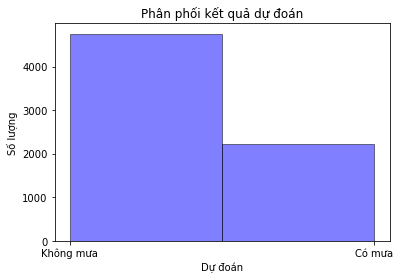

In [6]:
# Set the classpath to include the JAR file
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/jovyan/spark-streaming-kafka-0-8-assembly_2.11-2.0.0-preview.jar pyspark-shell'

# Initialize a SparkSession
spark = SparkSession.builder.appName("Kafka Weather Training Model ").config("spark.driver.allowMultipleContexts", "true").config("hive.metastore.uris", "thrift://hive-metastore:9083").config("spark.sql.warehouse.dir", "hdfs://namenode:9000/hive").enableHiveSupport().getOrCreate()
sqlContext = SQLContext(spark)



data = sqlContext.sql("""
    SELECT * FROM WeatherData 
""")

data = data.drop("rain")
data = data.drop("day")


# Xếp loại các loại thời tiết thành 2 dạng là có mưa và không mưa
list_norain = ['Clear', 'Cloudy', 'Mist', 'Sunny', 'Partly cloudy', 'Thundery outbreaks possible']
list_rain = ['Light drizzle','Light rain','Light rain shower', 'Patchy light drizzle', 'Patchy light rain', 
             'Patchy light rain with thunder','Patchy rain possible','Heavy rain','Heavy rain at times',
             'Moderate or heavy rain shower','Moderate rain', 'Moderate rain at times', 'Overcast','Torrential rain shower']

conditions = [
    data['weather'].isin(list_norain),  # Check if 'weather' is in list_norain
    data['weather'].isin(list_rain),    # Check if 'weather' is in list_rain
]

# Define corresponding values for each condition
values = ['norain', 'rain']

# Use the 'when' and 'lit' functions to create a new column 'predict'
data = data.withColumn('predict', when(conditions[0], values[0]).when(conditions[1], values[1]).otherwise('unknown'))

# Transformation for 'time' column
time_expr = when((col('time').cast("int") >= 6) & (col('time').cast("int") <= 15), "sang").otherwise("toi")
#sang: 0 toi: 1
time_label = when(data['time'] == 'sang', 0).otherwise(1)

data = data.withColumn('time', time_label)

# Transformation for 'month' column
month_expr = when(col('month').isin([5, 6, 7, 8, 9, 10, 11]), "mua").otherwise("kho")
#mua: 0 kho: 1
month_label = when(data['month'] == 'mua', int(0)).otherwise(int(1))
data = data.withColumn('month', month_label)

# Tạo cột nhãn 'label' cho mô hình
label_expr = when(data['predict'] == 'rain', int(1)).otherwise(int(0))
data = data.withColumn('label', label_expr)

data.show()
# Split the data into training (90%) and testing (10%) sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=100000)

# Define feature columns
feature_columns = ['temperature', 'feelslike', 'wind', 'cloud', 'pressure','time','month']

# Combine features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Tạo mô hình LinearSVC
lsvc = LinearSVC(labelCol="label", maxIter=50)

# Fit mô hình vào dữ liệu huấn luyện
lsvc_model = lsvc.fit(train_data)
#Chay Lan Dau
#lsvc_model.write().overwrite().save('/home/jovyan/model')
#lsvc_model.save('/home/jovyan/model')

#Chay Lan Sau
#lsvc_model.write().overwrite().save('/home/jovyan/model')

# Dự đoán trên dữ liệu kiểm tra
predictions = lsvc_model.transform(test_data)

# Hiển thị kết quả dự đoán
predictions.show(5)


# Lấy kết quả dự đoán từ DataFrame
predictions = lsvc_model.transform(test_data)

# Chọn cột prediction (kết quả dự đoán) từ DataFrame
prediction_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Vẽ biểu đồ phân phối dự đoán
plt.hist(prediction_values, bins=2, alpha=0.5, color='b', edgecolor='black')
plt.xlabel("Dự đoán")
plt.ylabel("Số lượng")
plt.title("Phân phối kết quả dự đoán")
plt.xticks([0, 1], ["Không mưa", "Có mưa"])
plt.show()


In [7]:

# Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Sử dụng mô hình để dự đoán dữ liệu mới
new_data = spark.createDataFrame([(29.97, 36.97, 0, 20, 1013,1,1)],
                                  ["temperature", "feelslike", "wind", "cloud",  "pressure","time","month"])
#Received message: {"temperature": 29.97, "feelslike": 36.97, "wind": 0, "cloud": 20, "humidity": 84, "pressure": 1013, "time": "sang", "month": "mua"}
# Áp dụng các biến đổi cho dữ liệu mới
#new_data = new_data.withColumn('time', time_expr)
#new_data = new_data.withColumn('month', month_expr)
new_data = assembler.transform(new_data)

# Dự đoán thời tiết mới
predictions_new_data = lsvc_model.transform(new_data)

# Hiển thị kết quả dự đoán cho dữ liệu mới
predictions_new_data.show()





Accuracy: 0.8753403066341883
+-----------+---------+----+-----+--------+----+-----+--------------------+--------------------+----------+
|temperature|feelslike|wind|cloud|pressure|time|month|            features|       rawPrediction|prediction|
+-----------+---------+----+-----+--------+----+-----+--------------------+--------------------+----------+
|      29.97|    36.97|   0|   20|    1013|   1|    1|[29.97,36.97,0.0,...|[3.13780891693668...|       0.0|
+-----------+---------+----+-----+--------+----+-----+--------------------+--------------------+----------+



In [8]:
# Dừng phiên Spark
spark.stop()

In [9]:
spark = SparkSession.builder.appName("SVMExample").getOrCreate()

loaded_model = LinearSVCModel.load("/home/jovyan/model")
print(loaded_model)
new_data = spark.createDataFrame([(29.97, 36.97, 0, 20, 1013)],
                                  ["temperature", "feelslike", "wind", "cloud", "pressure"])
        # Define feature columns
feature_columns = ['temperature', 'feelslike', 'wind', 'cloud', 'pressure']

        # Combine features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
new_data = assembler.transform(new_data)

        # Make predictions for the new data
predictions_new_data = loaded_model.transform(new_data)

        # Show the prediction results for the new data
predictions_new_data.show()   
spark.stop()

LinearSVC_5e4bc7342683


Py4JJavaError: An error occurred while calling o552.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 5.0 failed 1 times, most recent failure: Lost task 2.0 in stage 5.0 (TID 10, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 5, y.size = 6
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LinearSVCModel$$anonfun$12.apply(LinearSVC.scala:320)
	at org.apache.spark.ml.classification.LinearSVCModel$$anonfun$12.apply(LinearSVC.scala:319)
	at org.apache.spark.ml.classification.LinearSVCModel.predictRaw(LinearSVC.scala:328)
	at org.apache.spark.ml.classification.LinearSVCModel.predictRaw(LinearSVC.scala:298)
	at org.apache.spark.ml.classification.ClassificationModel$$anonfun$1.apply(Classifier.scala:168)
	at org.apache.spark.ml.classification.ClassificationModel$$anonfun$1.apply(Classifier.scala:167)
	... 22 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 5, y.size = 6
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LinearSVCModel$$anonfun$12.apply(LinearSVC.scala:320)
	at org.apache.spark.ml.classification.LinearSVCModel$$anonfun$12.apply(LinearSVC.scala:319)
	at org.apache.spark.ml.classification.LinearSVCModel.predictRaw(LinearSVC.scala:328)
	at org.apache.spark.ml.classification.LinearSVCModel.predictRaw(LinearSVC.scala:298)
	at org.apache.spark.ml.classification.ClassificationModel$$anonfun$1.apply(Classifier.scala:168)
	at org.apache.spark.ml.classification.ClassificationModel$$anonfun$1.apply(Classifier.scala:167)
	... 22 more
